In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # Use seaborn's default style to make beautifull graphs

import pandas as pd
import numpy as np

import folium
from geopy.geocoders import Nominatim

In [25]:
#emdat_data = pd.read_excel("data/public_emdat_incl_hist_2024-03-26.xlsx")
emdat_data = pd.read_csv(f"updated_emdat_data.csv")

In [26]:
emdat_data.columns

Index(['DisNo.', 'Historic', 'Classification Key', 'Disaster Group',
       'Disaster Subgroup', 'Disaster Type', 'Disaster Subtype',
       'External IDs', 'Event Name', 'ISO', 'Country', 'Subregion', 'Region',
       'Location', 'Origin', 'Associated Types', 'OFDA/BHA Response', 'Appeal',
       'Declaration', 'AID Contribution ('000 US$)', 'Magnitude',
       'Magnitude Scale', 'Latitude', 'Longitude', 'River Basin', 'Start Year',
       'Start Month', 'Start Day', 'End Year', 'End Month', 'End Day',
       'Total Deaths', 'No. Injured', 'No. Affected', 'No. Homeless',
       'Total Affected', 'Reconstruction Costs ('000 US$)',
       'Reconstruction Costs, Adjusted ('000 US$)',
       'Insured Damage ('000 US$)', 'Insured Damage, Adjusted ('000 US$)',
       'Total Damage ('000 US$)', 'Total Damage, Adjusted ('000 US$)', 'CPI',
       'Admin Units', 'Entry Date', 'Last Update'],
      dtype='object')

In [27]:
# If multiple countries are affected, each will have an entry linked to the same Dis No.
emdat_data["Country"].unique()

array(['Türkiye', 'Japan', 'Soviet Union', 'Guatemala', 'China', 'Israel',
       'Iran (Islamic Republic of)', 'Taiwan (Province of China)',
       'Greece', 'Italy', 'India', 'Albania', 'Colombia',
       'United States of America', 'Chile', 'Jamaica', 'France',
       'Morocco', 'Portugal', 'Pakistan', 'Costa Rica', 'Algeria',
       'Kazakhstan', 'Mexico', 'Romania', 'Peru', 'Indonesia',
       'Puerto Rico', 'Philippines', 'Argentina', 'Ecuador', 'Egypt',
       'Jordan', 'Canada', 'New Zealand', 'Myanmar', 'Nicaragua',
       'Solomon Islands', 'Armenia', 'El Salvador', 'Ghana',
       'Yemen Arab Republic', 'Yugoslavia', 'Dominican Republic',
       'Venezuela (Bolivarian Republic of)', 'Papua New Guinea', 'Haiti',
       'Cyprus', 'Afghanistan', 'Lebanon', 'Spain', 'Mongolia', 'Tunisia',
       'Ethiopia', 'Libya', 'Azores Islands',
       'United Republic of Tanzania', 'Uganda', 'Nepal', 'Australia',
       'South Africa', 'Iceland', 'Democratic Republic of the Congo',
       

In [28]:
emdat_data["Subregion"].unique() 

array(['Western Asia', 'Eastern Asia', 'Eastern Europe',
       'Latin America and the Caribbean', 'Southern Asia',
       'Southern Europe', 'Northern America', 'Western Europe',
       'Northern Africa', 'Central Asia', 'South-eastern Asia',
       'Australia and New Zealand', 'Melanesia', 'Sub-Saharan Africa',
       'Northern Europe', 'Polynesia', 'Micronesia'], dtype=object)

In [29]:
emdat_data["Region"].unique()

array(['Asia', 'Europe', 'Americas', 'Africa', 'Oceania'], dtype=object)

In [30]:
emdat_data["Location"] , len(emdat_data["Location"].unique())

(0                             KARS,KARAKURT,KAGIZMAN,DIGOR
 1                                                  Sanriku
 2                           Andishan,Tashkent (Uzbekistan)
 3                                Quezaltenango, San Marcos
 4                                     Semacha (Azerbaijan)
                                ...                        
 26438                                                Dakha
 26439                                                  NaN
 26440              Between Santa Rosa de Copan and Gracias
 26441                                      Niéna-Koumantou
 26442    Boyaca, Cordoba, Cundinamarca, Huila, Santande...
 Name: Location, Length: 26443, dtype: object,
 20361)

Text(0.5, 1.0, 'Percentage of missing values in each column')

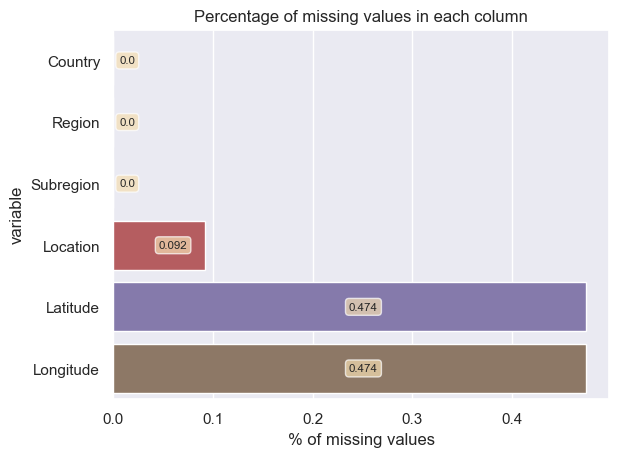

In [31]:
columns = ["Country","Region","Subregion","Location","Latitude","Longitude"]

fig, ax = plt.subplots()
sns.barplot(pd.DataFrame(emdat_data[columns].isna().mean()).reset_index().rename(columns={"index":"variable", 0:"% of missing values"}), y="variable", x="% of missing values", ax=ax, hue="variable", legend=False)
for i in ax.containers:
    ax.bar_label(
        i,
        fmt="{:.3}",
        label_type="center",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.7),
        padding=10,
        fontsize="x-small",
    )
# set title
ax.set_title("Percentage of missing values in each column")

We almost don't have longitude and latitulde information, so start by using the disasters that have it
Then use locations columns, to obtain that info
Then if neither location use the country information with location at the center

Good idea to already preprocces all that data before, like add it to a our version of the data, to avoid the need to run when loading the page

In [21]:
# Function to geocode location names to latitude and longitude
def geocode_location(location,geolocator):
    try:
        query = f"{location}"
        location = geolocator.geocode(query)
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except Exception as e:
        print(f"Error geocoding {location}: {str(e)}")
        return None, None

In [24]:
# Check the number of missing locations of the cvs file
data = pd.read_csv(f"updated_emdat_data.csv")

missing_coords = data[data['Latitude'].isna() | data['Longitude'].isna()]
total_missing = len(missing_coords)
print(f"Total missing locations to geocode: {total_missing}")

Total missing locations to geocode: 12534


In [23]:
# Initialize a geocoder
geolocator = Nominatim(user_agent="my_geocoder")

# Apply geocoding to locations with missing latitude and longitude
missing_coords = emdat_data[emdat_data['Latitude'].isna() | emdat_data['Longitude'].isna()]
total_missing = len(missing_coords)
print(f"Total missing locations to geocode: {total_missing}")

# Reset progress counter
progress_counter = 0

# Save interval
save_interval = 1000
save_counter = 0

# Apply geocoding and track progress
for index, row in missing_coords.iterrows():

    # Geocode location
    latitude, longitude = geocode_location(row['Location'], geolocator)

    # Update latitude and longitude in DataFrame
    missing_coords.at[index, 'Latitude'] = latitude
    missing_coords.at[index, 'Longitude'] = longitude

    # Update progress
    progress_counter += 1
    print(f"Progress: {progress_counter}/{total_missing} ({(progress_counter/total_missing)*100:.2f}%)")

    # Check if it's time to save the data
    if progress_counter % save_interval == 0:
        print("Saving progress...")
        # Concatenate with existing data and save to CSV
        pd.concat([emdat_data.drop(missing_coords.index), missing_coords]).to_csv(f'updated_emdat_data_{save_counter}.csv', index=False)

        # Increment save counter
        save_counter += 1

# Save the final updated data to a new CSV file
final_data = pd.concat([emdat_data.drop(missing_coords.index), missing_coords])
final_data.to_csv('updated_emdat_data.csv', index=False)

Total missing locations to geocode: 23653
Progress: 1/23653 (0.00%)
Progress: 2/23653 (0.01%)
Progress: 3/23653 (0.01%)
Progress: 4/23653 (0.02%)
Progress: 5/23653 (0.02%)
Progress: 6/23653 (0.03%)
Progress: 7/23653 (0.03%)
Progress: 8/23653 (0.03%)
Progress: 9/23653 (0.04%)
Progress: 10/23653 (0.04%)
Progress: 11/23653 (0.05%)
Progress: 12/23653 (0.05%)
Progress: 13/23653 (0.05%)
Progress: 14/23653 (0.06%)
Progress: 15/23653 (0.06%)
Progress: 16/23653 (0.07%)
Progress: 17/23653 (0.07%)
Progress: 18/23653 (0.08%)
Progress: 19/23653 (0.08%)
Progress: 20/23653 (0.08%)
Progress: 21/23653 (0.09%)
Progress: 22/23653 (0.09%)
Progress: 23/23653 (0.10%)
Progress: 24/23653 (0.10%)
Progress: 25/23653 (0.11%)
Progress: 26/23653 (0.11%)
Progress: 27/23653 (0.11%)
Progress: 28/23653 (0.12%)
Progress: 29/23653 (0.12%)
Progress: 30/23653 (0.13%)
Progress: 31/23653 (0.13%)
Progress: 32/23653 (0.14%)
Progress: 33/23653 (0.14%)
Progress: 34/23653 (0.14%)
Progress: 35/23653 (0.15%)
Progress: 36/23653 (0.

In [ ]:
"""# Create a map centered around a specific location
m = folium.Map(location=[emdat_data['Latitude'].mean(), emdat_data['Longitude'].mean()], zoom_start=5)

# Add markers for each disaster location
for index, row in emdat_data.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']], popup=row['Location']).add_to(m)

# Save the map to an HTML file
m.save('disaster_map.html')
"""